In [1]:
import time
import matplotlib.pyplot as plt
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from torch import nn, optim
from utils import *
from lib import load_cifar10_data
from torch.utils.data import DataLoader

In [28]:
print('General setup ...')
end_epoch = 256 # 50 epoch, use convolutional neural network
show_history = True
# seeds_rngs() # reset all random number generatars
lr = 0.0001 # learning rate
lr_decay = float(1-1e-3) # exponential decay learning rate per epoch
batch_size = 1024 # batch size
# save_path = '/content/drive/MyDrive/DeepLearningProjects/classification/cifar-10'
save_path = 'model_checkpoints'

General setup ...


In [16]:
print('Load and prepare data ...')
# this is wrapper function to load the images, and there labels of the training, validation and test sets to 
# two giants arrays,`all_X` contains all images, and `all_y` contains the labels
all_X, all_y = load_cifar10_data() 
print(f"the shape of all_X {all_X.shape}") # 50000 rgb images of size 32x32 pixels per channel
print(f"the shape of all_y {all_y.shape}") # 50000 label vectors

Load and prepare data ...
the shape of all_X (50000, 3072)
the shape of all_y (50000, 10)


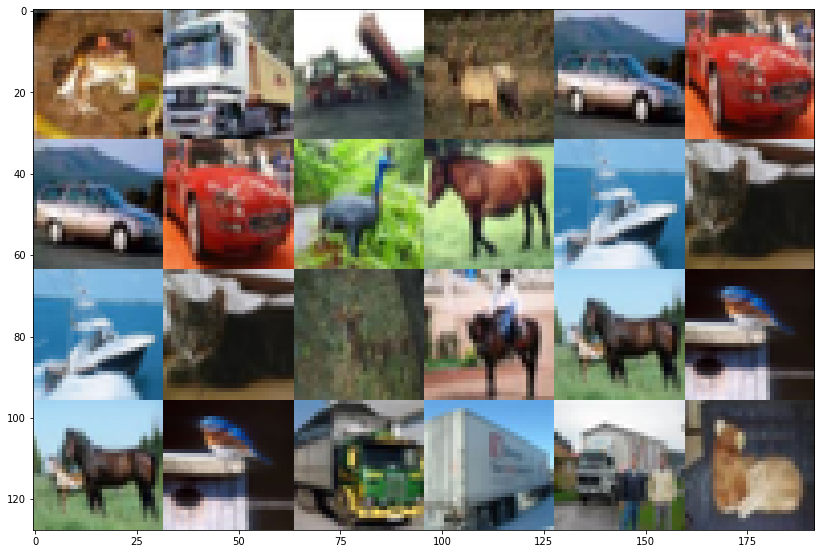

In [18]:
# if the neural network of type convolution, the shape of `all_X` ndarray should be depthxwithxheight
all_X = all_X.reshape(-1, 3, 32, 32)
# Dataset visualisation
display_samples(all_X[:4*6], shape=(4, 6))

In [19]:
# normalization over the training set
train_samples = int((0.8**2)*all_X.shape[0]) # number of samples in the trainset
all_X_mean = np.mean(all_X[:train_samples], axis=(0, 2, 3)).reshape(1, 3, 1, 1) # compute the mean
all_X_std = np.std(all_X[:train_samples], axis=(0, 2, 3)).reshape(1, 3, 1, 1) # compute the std deviation
all_X = (all_X - all_X_mean) / all_X_std # normalization of the whole dataset(train, validation, test)
# all_X = np.asarray(all_X, dtype=np.float16)
# all_y = np.asarray(all_y, dtype=np.float16)

In [20]:
# Split the dataset to train, validation and test datasets
train_X_y, valid_X_y, test_X_y = split2tvt(all_X, all_y, train_ratio=0.8, shuffle=True) # check the function defi
del all_X, all_y

In [21]:
print('Construting datasets ...')
# Constructing the datasets, taking into account the batch size to use 
trainset = DataLoader(train_X_y, batch_size=batch_size, shuffle=False)
validset = DataLoader(valid_X_y, batch_size=2*batch_size, shuffle=False)
testset = DataLoader(test_X_y, batch_size=2*batch_size, shuffle=False)

Construting datasets ...


In [25]:
print('Defining neural networks ...')
cv_kernels = ((3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)) # kernels per layer
cv_strides = ((1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)) # strides per layer
cv_padding = ((1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)) # padding per layer
cv_layout = (3, 16, 64, 128, 128, 256, 256, 256) # depth per layer 
cv_maxpool = [False, True, False, True, False, False, True] # maxpool layer or not
cv_dropout = [True, True, True, True, True, True, True] # dropout per layer
cv_pdrop = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4] # dropout per layer
cv_batchnorm = [True, True, True, True, True, True, True] # batch normalisation per layer
cv2linear_size = (4, 4) # hack to add or not the adaptive avg pooling
cv_lnlayout  = (128, 10)
net = ConvNet(cv_maxpool=cv_maxpool, cv_layout=cv_layout, cv_kernels=cv_kernels,\
        cv_strides=cv_strides, cv_padding=cv_padding, use_avgpool=False, \
        cv2linear_size=cv2linear_size, cv_dropout=cv_dropout, cv_batchnorm=cv_batchnorm, \
        cv_lnlayout=cv_lnlayout, cv_pdrop=cv_pdrop)
net.to(device)
print(f"the network architecture: \n{net}")

Defining neural networks ...
the network architecture: 
ConvNet(
  (cv_layers): ModuleList(
    (0): Sequential(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout2d(p=0.4, inplace=True)
      (relu): ReLU(inplace=True)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout2d(p=0.4, inplace=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout2d(p=0.4, inplace=True)
      (relu): ReLU(inplace=True)
      (batchnorm): BatchNorm2d(128, eps=1e-05, mom

In [26]:
print('Defining optimizer and cost function ...')
loss_func = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(params=net.parameters(), lr=lr, betas=(0.92, 0.999), \
        eps=1e-8, weight_decay=0.002, amsgrad=False)

Defining optimizer and cost function ...


In [27]:
print('Starting training ...')
start = time.time()
loss_history = train_net(net, trainset, validset, loss_func=loss_func, optimizer=optimizer,
        start_epoch=0, end_epoch=512, batch_log=64, learn_decay=lr_decay, save_path=save_path, \
        debug=False, debug_epoch=8, prefix='classification-cifar-10', resume=False)
end = time.time()
print('Finishing training ...')

Starting training ...
Epoch   1/512, loss: 0.736511 ------------------------
Epoch   2/512, loss: 0.734359 ------------------------
Epoch   3/512, loss: 0.734369 ------------------------
Epoch   4/512, loss: 0.732931 ------------------------
Epoch   5/512, loss: 0.730655 ------------------------
Epoch   6/512, loss: 0.728183 ------------------------
Epoch   7/512, loss: 0.726397 ------------------------
Epoch   8/512, loss: 0.723644 ------------------------
>> Cost: 0.723644, Training accuracy: 27.52, Validation accuracy: 27.55

Epoch   9/512, loss: 0.721968 ------------------------
Epoch  10/512, loss: 0.720922 ------------------------
Epoch  11/512, loss: 0.722045 ------------------------
Epoch  12/512, loss: 0.719978 ------------------------
Epoch  13/512, loss: 0.717702 ------------------------
Epoch  14/512, loss: 0.716031 ------------------------
Epoch  15/512, loss: 0.717879 ------------------------
Epoch  16/512, loss: 0.717037 ------------------------
>> Cost: 0.717037, Traini

In [31]:
for g in optimizer.param_groups:
    print(g['lr'])

5.991422854295222e-05


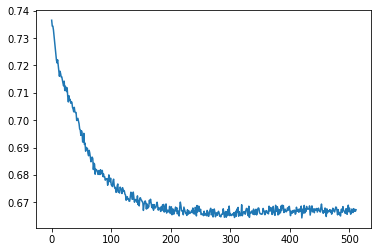

In [29]:
if show_history:
    f, a = plt.subplots()
    a.plot(loss_history.detach().numpy())
    f.canvas.draw()
    f.canvas.flush_events()
    plt.show()

In [32]:
print(f'Training time: {end-start}')

Training time: 3216.9780888557434


In [33]:
train_loss = fc(net, trainset)
valid_loss = fc(net, validset)
test_loss = fc(net, testset)

In [34]:
print(f'\n\nComputing the performance of the model...')
print(f'\nTraining accuracy: {train_loss},        Validation accuracy: {valid_loss},        Test accuracy: {test_loss}\n')



Computing the performance of the model...

Training accuracy: 84.79,        Validation accuracy: 74.55,        Test accuracy: 75.29

